# DSAI Mini-project
## Network Intrusion Detection using

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

sns.set_style('darkgrid')

This dataset is in regards to the resale pricing of HDBs in Singapore, contain details such as the type of HDB, size and etc. Our main goal for this study is to create an Regression model that is able to accurately predict the resale price of the houses, providing people with a tool that is able to estimate the worth of their home when they are considering to sell.

Due to the multiple datasets chunked into different yearly intervals, we are required to read all of them and concat them into a single dataset before analysing

In [2]:
dfs = [] 
for file in os.listdir('./datasets'):
    dfs.append(pd.read_csv(f"./datasets/{file}"))

df = pd.concat(dfs)
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0,NaN
1,2000-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0,NaN
2,2000-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0,NaN
3,2000-01,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0,NaN
4,2000-01,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0,NaN


Overall there are up to 660,656 entries in our dataset with 11 columns. 

In [3]:
df.shape

(660656, 11)

### Exploratory Data Analysis
First we will conduct EDA on our dataset try to understand what we are working with. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 660656 entries, 0 to 201648
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                660656 non-null  object 
 1   town                 660656 non-null  object 
 2   flat_type            660656 non-null  object 
 3   block                660656 non-null  object 
 4   street_name          660656 non-null  object 
 5   storey_range         660656 non-null  object 
 6   floor_area_sqm       660656 non-null  float64
 7   flat_model           660656 non-null  object 
 8   lease_commence_date  660656 non-null  int64  
 9   resale_price         660656 non-null  float64
 10  remaining_lease      238802 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 60.5+ MB


### Dataset Details 

The dataset contains 2 float64 columsn, 1 int64 column as well as 8 object columns, and their details are as follows 

- month (object) – The month in which the resale transaction took place, formatted as "YYYY-MM".
- town (object) – The town or estate in Singapore where the HDB flat is located (e.g., Ang Mo Kio, Bedok, Jurong West).
- flat_type (object) – The type of HDB flat based on the number of rooms, such as "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", etc.
- block (object) – The block number of the HDB flat.
- street_name (object) – The name of the street where the block is located.
- storey_range (object) – The range of floors where the unit is located, typically in ranges like "01 TO 03", "04 TO 06", etc.
- floor_area_sqm (float64) – The size of the flat in square meters (sqm).
- flat_model (object) – The specific model of the flat (e.g., "Improved", "New Generation", "Model A", "Maisonette"), indicating the design and layout.
- lease_commence_date (int64) – The year when the lease for the flat started.
- resale_price (float64) – The transaction price of the flat in Singapore dollars (SGD).
- remaining_lease (object) – The remaining lease period of the flat at the time of the transaction (e.g., "85 years 2 months"). This column has many missing values, possibly due to it not being recorded for older transactions.

In [5]:
df.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,660656.000000,660656.000000,6.606560e+05
mean,96.691427,1990.789499,3.744205e+05
std,25.003802,11.673915,1.744986e+05
min,28.000000,1966.000000,2.800000e+04
25%,74.000000,1983.000000,2.450000e+05
50%,95.000000,1988.000000,3.480000e+05
75%,113.000000,1999.000000,4.650000e+05
max,366.700000,2021.000000,1.600000e+06


In [6]:
df.describe(include='object')

,month,town,flat_type,block,street_name,storey_range,flat_model,remaining_lease
count,660656,660656,660656,660656,660656,660656,660656,238802
unique,303,26,7,2734,578,25,21,735
top,2010-07,WOODLANDS,4 ROOM,2,YISHUN RING RD,04 TO 06,Model A,68
freq,3679,57365,262762,2726,10767,161899,202889,2328


## Data cleaning

The month column in the dataframe is the month in which the resale transaction took place. However as it contains a mix of both the month and year, it is not very useful as it is. Hence, we decided to split it into different individual columns (year_recorded, month_recorded) for further analysis, which would be used later in this project.

In [79]:
df['year_recorded']  = df['month'].apply(lambda x: x.split('-')[0])
df['month_recorded'] = df['month'].apply(lambda x: x.split('-')[1])
df.drop(['month'], axis=1, inplace=True)
df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year_recorded,month_recorded
0,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0,NaN,2000,01
1,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0,NaN,2000,01
2,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0,NaN,2000,01
3,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0,NaN,2000,01
4,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0,NaN,2000,01


Next, we check if there are any null or missing values in our dataset that we may need to handle, in preparation to clean and preprocess the data for a more accurate analysis and modeling

In [80]:
missing_values = df.isnull().sum()
missing_values

town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        421854
year_recorded               0
month_recorded              0
dtype: int64

Generally, we can see that our dataset has no null values for most columns except for the column `remaining_lease`. However, it will not be an issue as we will be able to calculate the remaining lease by using the formula: `99 - (year_recorded - lease_commence_date)`.

Where 99 is the max starting lease that all Singapore HDBs have. But before overwriting, let's take a look at the `remaining_lease` to see if there are any significant details that we need to take note of.

In [7]:
df_with_rl = df[df['remaining_lease'].notnull()]
df_with_rl['remaining_lease']

0                         70
1                         65
2                         64
3                         63
4                         64
                 ...        
201644    66 years 04 months
201645    61 years 08 months
201646    62 years 07 months
201647    89 years 10 months
201648    62 years 06 months
Name: remaining_lease, Length: 238802, dtype: object

Looking at the info of `df_with_rl['remaining_lease']`, we identified that there is a mix of data inside our `remaining_lease` column, where some of the rows only have a year value while the others have a year and month string. To determine what to do with this, we decided to check if the years provided from the dataset matches the calculation of `99 - (year_recorded - lease_commence_date)`

In [82]:
df_with_rl = df_with_rl.copy()
df_with_rl['check_remaining_lease'] = 99 - (df_with_rl['year_recorded'].astype('int64') - df_with_rl['lease_commence_date'].astype('int64'))
df_with_rl

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year_recorded,month_recorded,check_remaining_lease
0,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,255000.0,70,2015,01,70
1,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,275000.0,65,2015,01,65
2,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,285000.0,64,2015,01,64
3,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,290000.0,63,2015,01,63
4,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,290000.0,64,2015,01,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...
201644,YISHUN,4 ROOM,631,YISHUN ST 61,01 TO 03,91.0,New Generation,1992,530000.0,66 years 04 months,2025,03,66
201645,YISHUN,4 ROOM,716,YISHUN ST 71,10 TO 12,88.0,Simplified,1987,515000.0,61 years 08 months,2025,03,61
201646,YISHUN,5 ROOM,860,YISHUN AVE 4,10 TO 12,122.0,Improved,1988,725000.0,62 years 07 months,2025,03,62
201647,YISHUN,5 ROOM,336C,YISHUN ST 31,04 TO 06,112.0,Improved,2015,688000.0,89 years 10 months,2025,03,89


From the above dataframe (`df_with_rl`) we see that the `check_remaining_lease` column values matches with the `remaining_lease` column. 

For the rows that contains month in the `remaining_lease` column, we have no choice but to remove the month detail to ensure standardisation for all rows, as we are not able to get the months for all the rows. 

To do this, we will just overwrite the entire column in our main dataset

In [83]:
df = df.copy()
df['remaining_lease'] = 99 - (df['year_recorded'].astype('int64') - df['lease_commence_date'].astype('int64'))
df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year_recorded,month_recorded
0,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0,85,2000,01
1,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0,85,2000,01
2,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0,75,2000,01
3,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0,75,2000,01
4,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0,75,2000,01


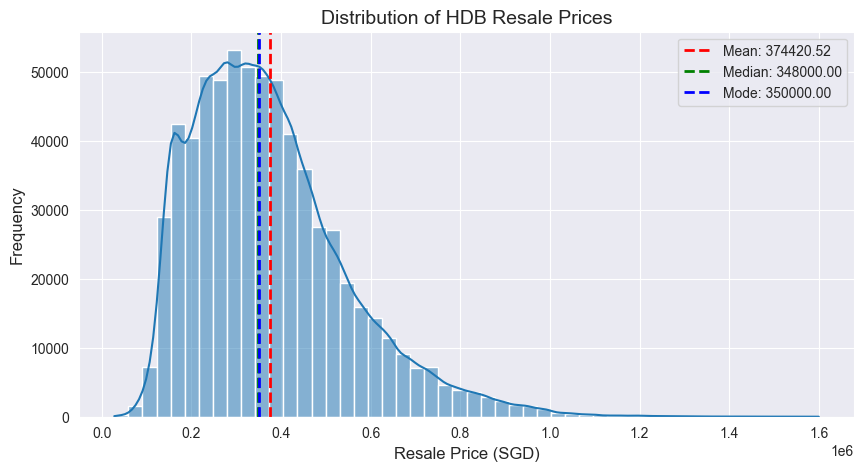

In [84]:
mean_price = df["resale_price"].mean()
median_price = df["resale_price"].median()
mode_price = df["resale_price"].mode()[0]  # Mode can return multiple values, take first

# Create histogram
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="resale_price", bins=50, kde=True)

# Plot vertical lines for mean, median, mode
plt.axvline(mean_price, color="red", linestyle="dashed", linewidth=2, label=f"Mean: {mean_price:.2f}")
plt.axvline(median_price, color="green", linestyle="dashed", linewidth=2, label=f"Median: {median_price:.2f}")
plt.axvline(mode_price, color="blue", linestyle="dashed", linewidth=2, label=f"Mode: {mode_price:.2f}")

# Titles & Labels
plt.title("Distribution of HDB Resale Prices", fontsize=14)
plt.xlabel("Resale Price (SGD)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.show()

In [85]:
print(f"Skewness score: {df['resale_price'].skew()}")

Skewness score: 1.0570945219718373


The histogram above shows a positive skew in the resale prices, suggesting the presence of outliers in the data. Its skewness is further supported by by the skewness score when using the skew function as it provides a skew value of 1.05, indicating that there are more values to the left of the mean and a few high values pulling the mean to the right.

This is important to consider when assessing model performance and choosing the right model. Models, such as linear regression, assume that the target variable follows a normal distribution, and skewed data can affect their accuracy an. To address this, we can transform the target feature by applying a logarithmic function to reduce the skewness, or choose models that are not sensistive to outliers such as lasso or ridge regression"

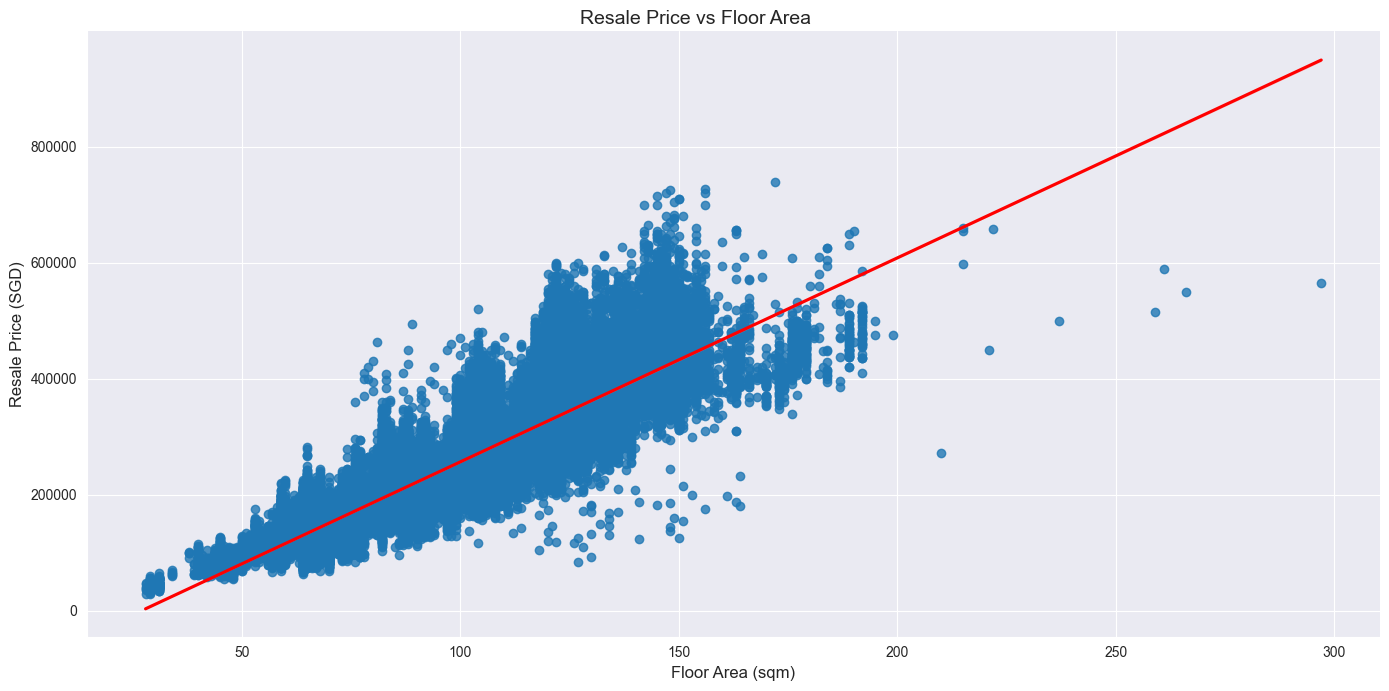

In [86]:
g = sns.lmplot(data=df[:100000], x='floor_area_sqm', y='resale_price', height=7, aspect=2, line_kws={'color': 'red'})
# Add title, labels, and customize the plot
g.set_axis_labels('Floor Area (sqm)', 'Resale Price (SGD)', fontsize=12)
g.fig.suptitle('Resale Price vs Floor Area', fontsize=14)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)  # Adjust title so it doesn't overlap with the plot

# Show the plot
plt.show()

In [101]:
df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year_recorded,month_recorded
0,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0,85,2000,01
1,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0,85,2000,01
2,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0,75,2000,01
3,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0,75,2000,01
4,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0,75,2000,01


<Axes: xlabel='lease_commence_date', ylabel='floor_area_sqm'>

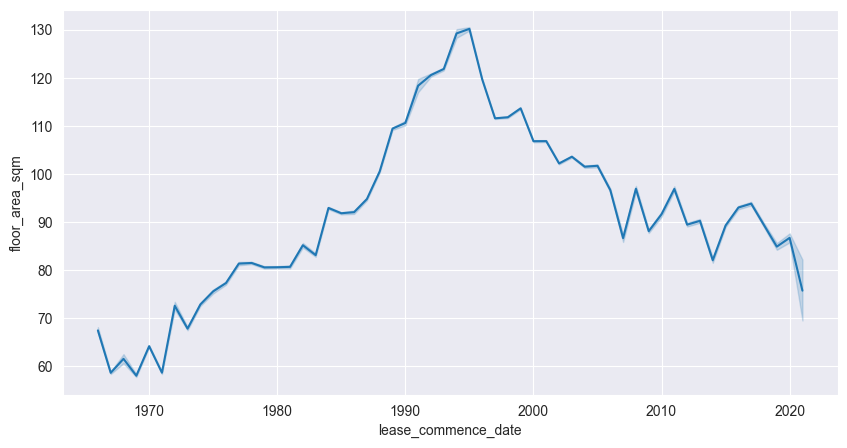

In [122]:
fig, (ax1) = plt.subplots(1,1, figsize=(10, 5))

sns.lineplot(data=df, x='lease_commence_date', y='floor_area_sqm', ax=ax1)

Check pressence of housing establishment as year go by for different locations 

In [124]:
df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year_recorded,month_recorded
0,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0,85,2000,01
1,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0,85,2000,01
2,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0,75,2000,01
3,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0,75,2000,01
4,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0,75,2000,01


### ML 

,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year_recorded,month_recorded
0,ANG MO KIO,3 ROOM,07 TO 09,69.0,Improved,1986,147000.0,85,2000,01
1,ANG MO KIO,3 ROOM,04 TO 06,61.0,Improved,1986,144000.0,85,2000,01
2,ANG MO KIO,3 ROOM,07 TO 09,73.0,New Generation,1976,159000.0,75,2000,01
3,ANG MO KIO,3 ROOM,07 TO 09,73.0,New Generation,1976,167000.0,75,2000,01
4,ANG MO KIO,3 ROOM,07 TO 09,67.0,New Generation,1976,163000.0,75,2000,01


In [152]:
ml_df = df.copy()
ml_df.drop(columns = ['block', 'street_name'], axis=1, inplace=True)
ml_df.head()
flat_type_order = {
    '1 ROOM': 1,
    '2 ROOM': 2,
    '3 ROOM': 3,
    '4 ROOM': 4,
    '5 ROOM': 5,
    'EXECUTIVE': 6,
    'MULTI-GENERATION': 7
}
ml_df['flat_type_encoded'] = ml_df['flat_type'].map(flat_type_order)
df_encoded = pd.get_dummies(ml_df, columns=['flat_model'], prefix='model', dtype=int)
df_encoded = pd.get_dummies(df_encoded, columns=['town'], prefix='town', dtype=int)
# Function to extract the middle value from a 'start TO end' range
def extract_middle(storey_range):
    try:
        start, end = storey_range.split(' TO ')
        return (int(start) + int(end)) / 2
    except:
        return None  # Handle any non-standard ranges (e.g., missing values)

# Apply the function to the 'storey_range' column
df_encoded['storey_range_middle'] = df_encoded['storey_range'].apply(extract_middle)

df_encoded.drop(['flat_type', 'lease_commence_date', 'year_recorded', 'storey_range'], axis=1, inplace = True)
df_encoded

,floor_area_sqm,resale_price,remaining_lease,month_recorded,flat_type_encoded,model_2-room,model_3Gen,model_Adjoined flat,model_Apartment,model_DBSS,...,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN,storey_range_middle
0,69.0,147000.0,85,01,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0
1,61.0,144000.0,85,01,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
2,73.0,159000.0,75,01,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0
3,73.0,167000.0,75,01,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0
4,67.0,163000.0,75,01,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201644,91.0,530000.0,66,03,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.0
201645,88.0,515000.0,61,03,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,11.0
201646,122.0,725000.0,62,03,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,11.0
201647,112.0,688000.0,89,03,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5.0


Train validation test

Look for AI models
-  Random forest regression 
- Ask gpt 

Metrics
- RMSE
- R2
- MAE

k fold cross val 

grid search hypertuning
